In [1]:
import numpy as np
import tensorflow as tf
import urllib.request
import os
import zipfile
from PIL import Image 
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from IPython.display import clear_output
import IPython.display as display

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4895736595142016443]

In [3]:
def preprocess(img):
    return (img / 127.5) - 1

#作成したpreprocess処理をもとに戻す。
def deprocess(img):
    img = img.copy()
    img /= 2.
    img += 0.5
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

# 画像を表示する。
def show(img):
    #plt.figure(figsize=(12,12))
    #plt.grid(False)
    #plt.axis('off')
    #plt.imshow(img)
    
    display.display(Image.fromarray(np.array(img)))

In [4]:
def forward(img):
    # バッチを作成
    img_batch = tf.expand_dims(img, axis=0)

    return feat_extraction_model(img_batch)

def calc_loss(layer_activations):
    total_loss = 0
    for act in layer_activations:
        # 要素の平均値を算出する
        loss = tf.math.reduce_mean(act)

        # レイヤー内の要素数で正規化を行う。
        loss /= np.prod(act.shape)
        total_loss += loss
        return total_loss

1
(432, 668, 3)


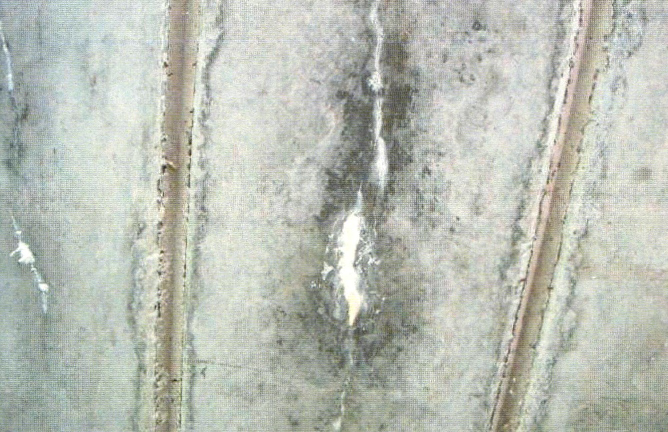

In [5]:
img = Image.open("51.jpg")
w = img.size[0]
h = img.size[1]
print(np.gcd.reduce(img.size))
gcf = np.gcd.reduce(img.size)
gcf = 2
img = img.resize((int(round(w/gcf)),int(round(h/gcf))))
img = preprocess(np.array(img))
print(img.shape)
show(deprocess(img))

In [6]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)
for i, layer in enumerate(inception_v3.layers):
    print(i,layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [7]:
# inceptionv3内で利用するレイヤを定義
#names = ['mixed2', 'mixed5', 'mixed7']
names = ["mixed0","mixed1","mixed2","mixed3","mixed4","mixed5","mixed6","mixed7","mixed8","mixed9","mixed10"]
layers = [inception_v3.get_layer(name).output for name in names]

# 特徴量を抽出するモデルを作成する。
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

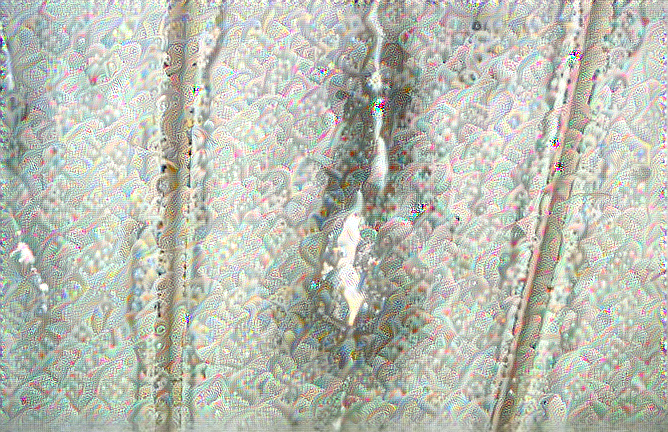

In [8]:
img = tf.Variable(img)

# 何回回すかを指定
steps = 1000

#OCTABE_SCALE = 1.3

#img = tf.constant(img)
#base_shape = tf.shape(img)[:-1]
#float_base_shape = tf.cast(base_shape, tf.float32)

for step in tqdm(range(steps)):

    #new_shape = tf.cast(float_base_shape*(OCTABE_SCALE**n),tf.int32)
    #print(new_shape)
    #img = tf.image.resize(img, new_shape).numpy()
    #img = tf.convert_to_tensor(img)
    #img = tf.Variable(img)

    with tf.GradientTape() as tape:
        #tape.watch(img)
        activations = forward(img)
        loss = calc_loss(activations)

    #勾配を計算する。
    gradients = tape.gradient(loss, img)

    # 勾配の正規化を行う
    gradients /= gradients.numpy().std() + 1e-8
    #gradients /= tf.math.reduce_std(gradients) + 1e-8

    #imgをアップデートする。
    img.assign_add(gradients)
    #img = img + gradients*tf.convert_to_tensor(0.1)
    #img = tf.clip_by_value(img,-1,1)

    if step % 10 == 0:
        clear_output()
        print ("Step %d, loss %f" % (step, loss))
        show(deprocess(img.numpy()))
        plt.show()


# 結果を出力する
clear_output()
show(deprocess(img.numpy()))

In [30]:
type(img)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [1]:
import tensorflow as tf
tf.__version__

'1.9.0'